## Data preparation and sanitization

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

from utils.preprocessing import df_to_xy

# Read and sanitize the data
df = pd.read_excel("../data/UG_HH_NEW_continuous_no200.xls")
#df = pd.read_excel("./UG_HH_NEW_categorical_no200.xls")
df = df.dropna()


x, y = df_to_xy(df, fuse_risk=True, centered=True, min_target=5, max_target=190)
## Usable columns: ['time_spent_risk', 'cells', 'selfish', 'time_spent_prop', 'count_effort', 
# ## 'Honesty_Humility','Extraversion', 'Agreeableness', 'min_offer']
# #df["effort"] = (1/df['time_spent_prop'] ) * (1/df['count_effort'])
# df_effort = df[['time_spent_prop', 'count_effort']]
# df_effort = (df_effort - df_effort.min()) / (df_effort.max() - df_effort.min())

# df['effort'] = df_effort['time_spent_prop'] * df_effort['count_effort']
# df = df[['time_spent_risk', 'cells', 'selfish', 'effort',
#          'Honesty_Humility','Extraversion', 'Agreeableness', 'min_offer']]

# df = df[['selfish','Honesty_Humility','Extraversion', 'Agreeableness', 'min_offer']]

# MAX_ACCEPTABLE_MIN_OFFER = 150
# df = df[df['min_offer'] <= MAX_ACCEPTABLE_MIN_OFFER]

# NORMALISE_DATA = True


# x = df.values[:, :-1]
# y = df.values[:, -1:]

# if NORMALISE_DATA:
#     x_min = x.min(axis=0)
#     x_max = x.max(axis=0)
#     x = (x - x_min) / (x_max - x_min)
    
# NB_FEATURES = x.shape[1]

/home/franck/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/franck/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/franck/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Linear regression (continuous dataset)

**Accuracy / Loss - For model comparison**

In [2]:
MAX_GAIN = 200


#### Benchmark

In [3]:
from utils.benchmark import process_benchmarks, process_benchmark_cv, process_model


Using TensorFlow backend.
/home/franck/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


**Keras Model**

In [4]:
from models import KerasModel, loss_tf, gain_tf

In [5]:
import os, sys


In [6]:
# #sci-kit like training
# sm = keras_model("mse") 
# history = sm.fit(xTrain, yTrain, validation_split=0.33, epochs=100, batch_size=64, verbose=0)
# loss_hist = pd.DataFrame(data={'loss': history.history['loss']})
# loss_hist.plot(figsize=(30,10))
# smPredict = sm.predict(xTest, batch_size=128)

# out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(smPredict)})
# stl = sm.evaluate(xTest, yTest, verbose=0)
# print("Results: %2.2f (%.2f) MSE, Scalar test loss: %.2f" % (smPredict.mean(), smPredict.std(), stl))
# #out_data.plot(figsize=(30,10))

**Featureless model (fixed value)**

In [7]:
from models import FeaturelessModel

**Convervative model**

In [8]:
from models import ConservativeModel

**Linear/Logistic regression**

In [9]:
from sklearn.linear_model import LinearRegression, LogisticRegression

**Random**

In [10]:
from models import RandomModel

**Random Forest**

In [11]:
from sklearn.ensemble.forest import RandomForestClassifier, RandomForestRegressor

**Clustering**

In [12]:
from models import ClusterModel, ClusterExtModel

In [13]:
from sklearn.neural_network import MLPClassifier

** Acceptance model **

In [14]:
from models import AcceptanceModel

** Data augmentation **

In [15]:
from utils.data_augmentation import DACombine

**Baseline models**

In [16]:
from sklearn.svm import SVC

benchmark_models = {
    #Featureless:
    #"random": RandomModel(MAX_GAIN),
    #"conservative": ConservativeModel(MAX_GAIN),
    "featureless": FeaturelessModel(MAX_GAIN),
    "svc": SVC(gamma='auto') 
#     "linear_regressor": LinearRegression(copy_X=False),
#     "linear_regressor_mse": keras_linear_regression(loss="mse"),
}

results = dict()
# for key, model in benchmark_models.items():
#     results[key] = process_benchmark_cv(model, x, y.ravel())
#     results[key+"_da"] = process_benchmark_cv(model, x, y.ravel(), augment_data=2)
#results = {key: process_benchmark_cv(model, x, y.ravel()) for key, model in benchmark_models.items()}
results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=[None, 2])

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
pd.DataFrame(results_mean).T

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
featureless,26.897619,0.218055,23.998552,963.0,1505.321429,0.066825
featureless_da2,40.242857,0.327719,38.656535,1439.0,2377.285714,0.055556
svc,26.897619,0.218055,23.998552,963.0,1505.321429,0.066825
svc_da2,73.723810,0.642315,25.881579,2641.0,7975.325397,0.558095


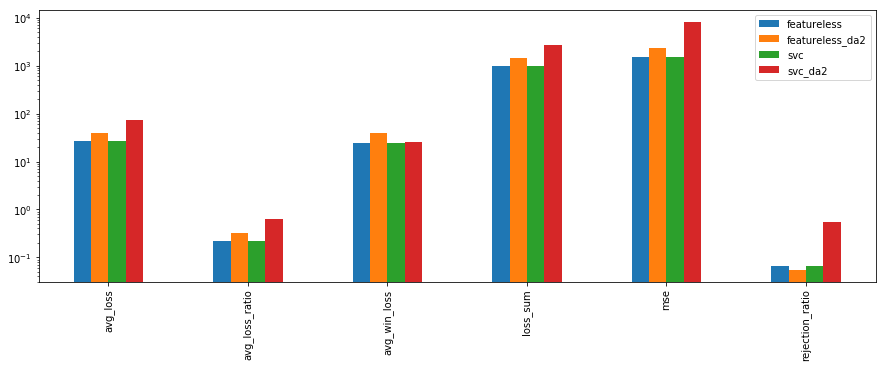

In [17]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))

**Clustering based models**

In [18]:
benchmark_models = {
#     #Cluster-based
    "affinity": ClusterModel(base_model="affinity"),
#     "bayes": ClusterModel(base_model="bayes", n_components=8),
#     "birch": ClusterModel(base_model="birch"),
#     "kmeans": ClusterModel(base_model="kmeans", n_clusters=16),
    "meanshift": ClusterModel(base_model="meanshift", cluster_all=True),
    "affinity_ext": ClusterExtModel(base_model="affinity"),
#     "bayes_ext": ClusterExtModel(base_model="bayes", n_components=8),
#     "birch_ext": ClusterExtModel(base_model="birch"),
#     "kmeans_ext": ClusterModel(base_model="kmeans", n_clusters=16),
    "meanshift_ext": ClusterExtModel(base_model="meanshift", cluster_all=True),
}

results = {key: process_benchmark_cv(model, x, y.ravel()) for key, model in benchmark_models.items()}

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
pd.DataFrame(results_mean).T

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
affinity,37.779206,0.325621,27.949628,1353.8,2480.991905,0.150000
affinity_ext,30.123016,0.247157,23.564694,1079.0,1967.440476,0.100159
meanshift,32.409524,0.261931,30.656535,1160.2,1766.825397,0.055556
meanshift_ext,26.897619,0.218055,23.998552,963.0,1505.321429,0.066825


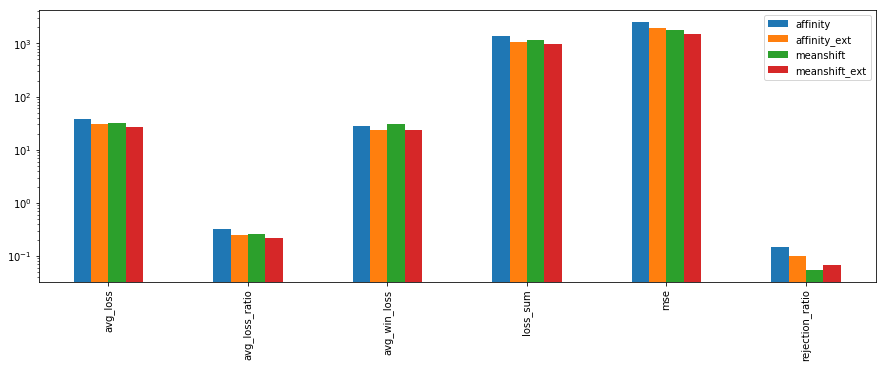

In [19]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))

**Other models**

In [20]:
benchmark_models = {
    'featureless': FeaturelessModel(),
    # Regression
    #"random_forest_regr": RandomForestRegressor(min_samples_leaf=5),
    'logistic_regression': LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto'),
    #"nn_regression_mse": keras_model(loss="mse"),
    #"nn_regression_ext": keras_model(loss=loss_tf),
    'acceptance_model': AcceptanceModel(step=10, zero_one=True),
    # Classification
    #"random_forest": RandomForestClassifier(min_samples_leaf=5),#max_depth=3, random_state=0, n_estimators=10),
}

results = dict()

results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=[None, 2])
results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
pd.DataFrame(results_mean).T

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
acceptance_model,29.519841,0.260859,21.036418,1057.0,1715.591270,0.128413
acceptance_model_da2,32.924603,0.297196,19.181603,1179.0,2287.480159,0.183810
featureless,26.897619,0.218055,23.998552,963.0,1505.321429,0.066825
featureless_da2,39.298413,0.319641,37.656535,1405.0,2322.841270,0.055556
logistic_regression,26.080159,0.229628,15.759543,933.0,1828.337302,0.133968
logistic_regression_da2,76.283333,0.657872,22.715278,2729.0,8413.638889,0.586984


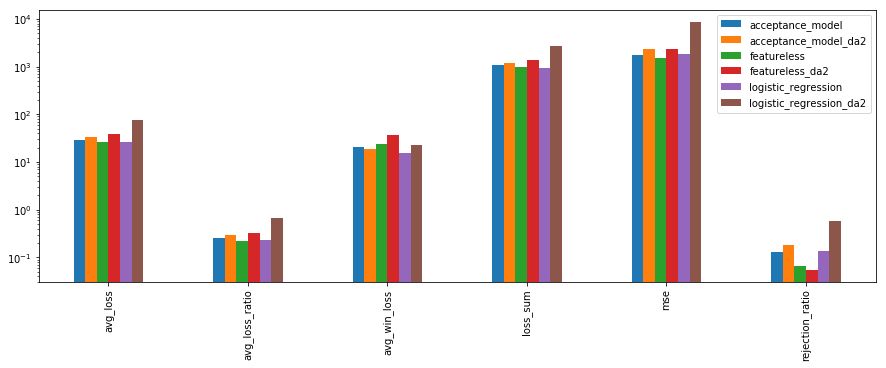

In [21]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))

**TOP MODELS**

In [25]:
from sklearn.svm import SVR
benchmark_models = {
    'featureless': FeaturelessModel(),
    'logistic_regression': LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto'),
    'svc': SVC(gamma='auto'),
    'acceptance_model': AcceptanceModel(step=10, zero_one=True),
    'acceptance_model_svr': AcceptanceModel(SVR(gamma='auto', kernel='poly', degree=1), step=10, zero_one=True),
    
    # Classification
    #"random_forest": RandomForestClassifier(min_samples_leaf=5),#max_depth=3, random_state=0, n_estimators=10),
}

results = dict()

results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=None, shuffle=True)
results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
pd.DataFrame(results_mean).T

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
acceptance_model,28.296032,0.246253,21.258593,1013.0,1603.059524,0.112063
acceptance_model_svr,27.515079,0.232567,23.938803,985.0,1355.694444,0.072857
featureless,26.899206,0.218379,23.952375,963.0,1506.313492,0.067302
logistic_regression,28.280159,0.246938,16.351148,1013.0,2118.376984,0.150952
svc,26.899206,0.218379,23.952375,963.0,1506.313492,0.067302


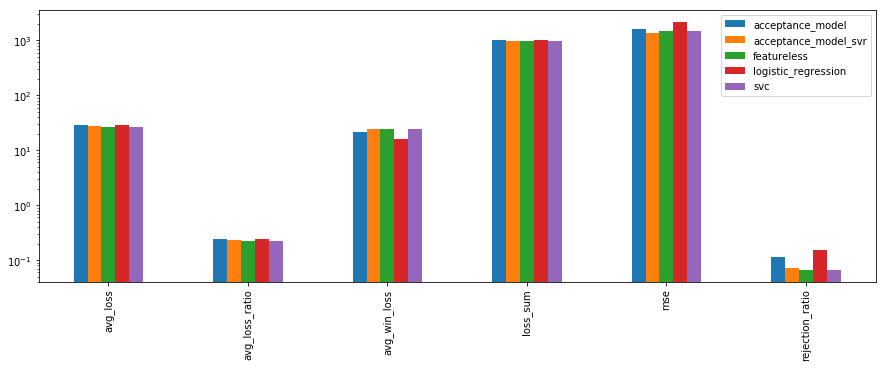

In [26]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))